## Demo: Importing Catalogue from Vizier
**LINCC FrameWorks** Lunch Talk Demo

Andy Tzanidais, April 25, 2024


### Getting Started
- First visit the VizieR Catalogue Collection: https://cdsarc.u-strasbg.fr/viz-bin/cat/
- Search catalogue ID number or reference (i.e., StarHorse)

In [100]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import astropy.units as u
%matplotlib inline
%config InlineBackend.figure_format = "retina"
from matplotlib import rcParams
rcParams['savefig.dpi'] = 550
rcParams['font.size'] = 20
plt.rc('font', family='serif')
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['axes.linewidth'] = 2

import lsdb
from tqdm import tqdm
import dask
dask.config.set({"temporary-directory" :'/epyc/ssd/users/atzanida/tmp'})
dask.config.set({"dataframe.shuffle-compression": 'Snappy'})
dask.config.set({"dataframe.convert-string": False})
from dask.distributed import Client

## ViZier and Aladin querying 
from pyvo import registry  # version >=1.4.1 
from mocpy import MOC
from ipyaladin import Aladin

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'dataframe.shuffle-compression' has been deprecated; please use 'dataframe.shuffle.compression' instead
  warnings.warn(


In [ ]:
# initialize dask client 
Client = Client(n_workers=8, threads_per_worker=1, memory_limit='auto')

## VizieR Querying

In [47]:
# the catalogue name in VizieR
CATALOGUE = "I/354"

# each resource in the VO has an identifier, called ivoid. For vizier catalogs,
# the VO ids can be constructed like this:
catalogue_ivoid = f"ivo://CDS.VizieR/{CATALOGUE}"

# the actual query to the registry
voresource = registry.search(ivoid=catalogue_ivoid)[0]

tables = voresource.get_tables()

# We can also extract the tables names for later use
tables_names = list(tables.keys())

In [48]:
print (f"Available table names: {tables_names}")

Available table names: ['I/354/starhorse2021']


In [49]:
# Let's read quickly the table description...
voresource.describe(verbose=True)

StarHorse2, Gaia EDR3 photo-astrometric distances
Short Name: I/354
IVOA Identifier: ivo://cds.vizier/i/354
Access modes: conesearch, hips#hips-1.0, tap#aux, web
Multi-capabilty service -- use get_service()

We present a catalogue of 362 million stellar parameters, distances, and
extinctions derived from Gaia's Early Data Release (EDR3) cross-matched with
the photometric catalogues of Pan-STARRS1, SkyMapper, 2MASS, and AllWISE. The
higher precision of the Gaia EDR3 data, combined with the broad wavelength
coverage of the additional photometric surveys and the new stellar-density
priors of the StarHorse code, allows us to substantially improve the accuracy
and precision over previous photo-astrometric stellarparameter estimates. At
magnitude G=14 (17), our typical precisions amount to 3% (15%) in distance,
0.13mag (0.15mag) in V-band extinction, and 140K (180K) in effective
temperature. Our results are validated by comparisons with open clusters, as
well as with asteroseismic and spectr

In [ ]:
# Select the first table name
first_table_name = tables_names[0]

In [ ]:
# Initialize TAP service
tap_service = voresource.get_service("tap")


# ADQL query
tap_records = voresource.get_service("tap").run_sync(
f'SELECT TOP 6000000 Source, RA_ICRS, DE_ICRS, teff50,\
logg50, met50, dist50, fidelity, GMAG0, "BP-RP0" from "{first_table_name}" WHERE (logg50>4.3) AND \
(logg50<4.72) AND (teff50<7220) AND \
(teff50>4000) AND (DE_ICRS BETWEEN -50 AND 50) AND (fidelity>=0.9) AND (Source BETWEEN 161269789918889472 AND 9361269790018889472)',
) 

In [ ]:
table0 = tap_records.to_table()

In [ ]:
# Convert to pandas dataframe
table_df = table0.to_pandas()

## Passing to LSDB

In [ ]:
%%time
# Hipscat catalogue with minimum threshold 1_000_000 per pixel
star_horse_cat = lsdb.from_dataframe(
    table_df,
    catalog_name="StarHorse",
    catalog_type="object",
    lowest_order=5, 
    highest_order=8, 
    ra_column="RA_ICRS", 
    dec_column="DE_ICRS", 
    threshold=1_000_000)

In [50]:
# Already completed this step...
fgk_object = lsdb.read_hipscat("/nvme/users/atzanida/tmp/sample_final_starhorse_hips")

## Visualize Sky Dirstribution

In [66]:
import astropy.units as u
from astropy.coordinates import SkyCoord
import healpy as hp
from healpy.newvisufunc import projview

def cat2hpx(lon, lat, nside, radec=True):
    """
    Convert a catalogue to a HEALPix map of number counts per resolution
    element.

    Parameters
    ----------
    lon, lat : (ndarray, ndarray)
        Coordinates of the sources in degree. If radec=True, assume input is in the icrs
        coordinate system. Otherwise assume input is glon, glat

    nside : int
        HEALPix nside of the target map

    radec : bool
        Switch between R.A./Dec and glon/glat as input coordinate system.

    Return
    ------
    hpx_map : ndarray
        HEALPix map of the catalogue number counts in Galactic coordinates
    """
    npix = hp.nside2npix(nside)
    
    if radec:
        eq = SkyCoord(lon, lat, 'icrs', unit='deg')
        l, b = eq.galactic.l.value, eq.galactic.b.value
    else:
        l, b = lon, lat

    # conver to theta, phi
    theta = np.radians(90. - b)
    phi = np.radians(l)

    # convert to HEALPix indices
    indices = hp.ang2pix(nside, theta, phi)

    idx, counts = np.unique(indices, return_counts=True)

    # fill the fullsky map
    hpx_map = np.zeros(npix, dtype=int)
    hpx_map[idx] = counts
    
    return hpx_map

%%time
Sky = SkyCoord(ra=fgk_comp['RA_ICRS_StarHorse'].values*u.deg, 
              dec=fgk_comp['DE_ICRS_StarHorse'].values*u.deg)

# convert coordinates to Galactic frame (l,b)
sky_gal = Sky.galactic

/tmp/ipykernel_42980/145638649.py:8: RuntimeWarning: divide by zero encountered in log
  hp.mollview(np.log(hpx_map), cmap='plasma', hold=True,min=-2, max=3,


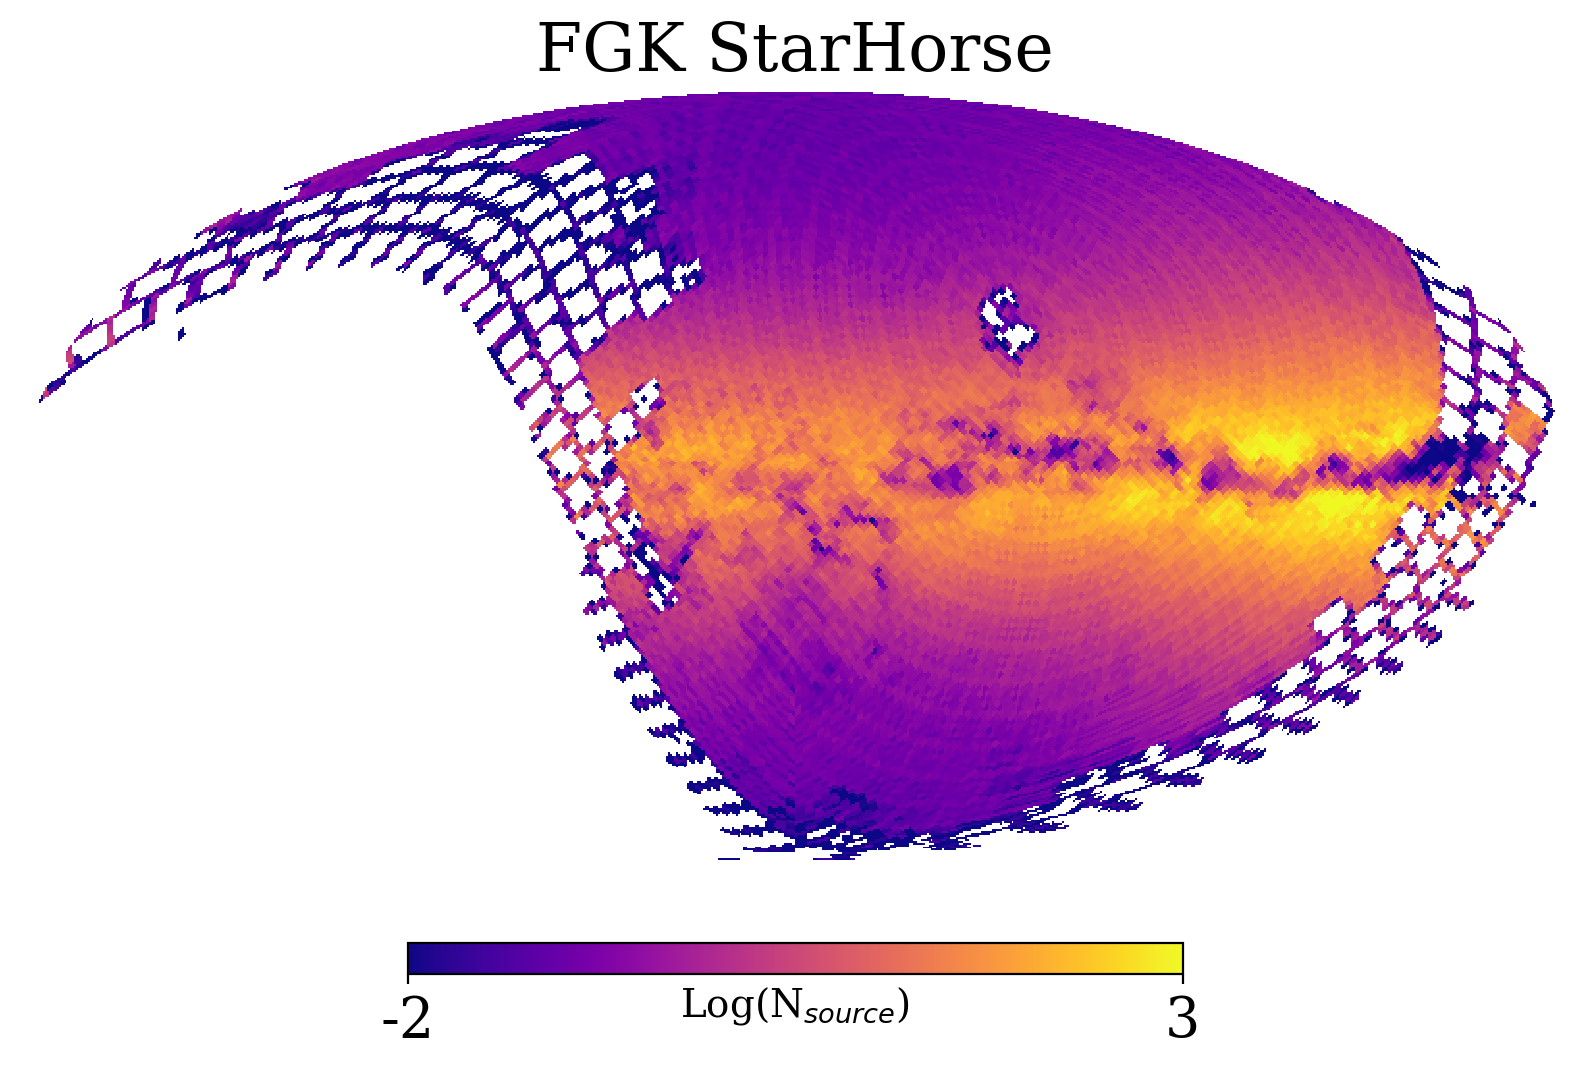

In [69]:
# Create Healpy projection 
hpx_map = cat2hpx(sky_gal.l.value-180,
                  sky_gal.b.value, 
                  nside=50, radec=False)

fig = plt.figure(figsize=(10,10))
plt.grid(True, color='k', lw=22)
hp.mollview(np.log(hpx_map), cmap='plasma', hold=True,min=-2, max=3,
                   flip='astro', remove_dip=False,
                   remove_mono=True, 
                  title='FGK StarHorse', 
           unit='Log(N$_{source}$)')

In [51]:
type(fgk_object)

lsdb.catalog.catalog.Catalog

In [52]:
fgk_object

,Source_StarHorse,RA_ICRS_StarHorse,DE_ICRS_StarHorse,teff50_StarHorse,logg50_StarHorse,met50_StarHorse,dist50_StarHorse,fidelity_StarHorse,GMAG0_StarHorse,BP-RP0_StarHorse,Norder_StarHorse,Dir_StarHorse,Npix_StarHorse,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,Norder,Dir,Npix
npartitions=99,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,uint8,uint64,uint64
288230376151711744,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12682136550675316736,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


In [58]:
%%time
query_1 = fgk_object.cone_search(ra=131.5, dec=11.5, radius_arcsec=350)

CPU times: user 19 ms, sys: 6.92 ms, total: 25.9 ms
Wall time: 24.2 ms


In [60]:
%%time
query_1.head(10)

CPU times: user 1.77 s, sys: 615 ms, total: 2.38 s
Wall time: 4.21 s


,Source_StarHorse,RA_ICRS_StarHorse,DE_ICRS_StarHorse,teff50_StarHorse,logg50_StarHorse,met50_StarHorse,dist50_StarHorse,fidelity_StarHorse,GMAG0_StarHorse,BP-RP0_StarHorse,...,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_DIST,Norder,Dir,Npix
_hipscat_index,,,,,,,,,,,,,,,,,,,,,
1197863561548791808,598931784973616640,131.516913,11.406418,5466.05,4.597045,-0.446562,1.330821,1.000000,5.618283,0.899752,...,16.747910,16.216818,16.053377,4,0,265,0.000026,1,0,4
1197675982639595520,598837978592281344,131.492180,11.407178,4971.93,4.597973,0.007115,1.182294,1.000000,6.117981,1.137367,...,17.290233,16.475666,16.239628,4,0,265,0.000032,1,0,4
1197863489494843392,598931716254139264,131.552034,11.431177,5832.03,4.387356,-0.173844,1.033428,1.000000,4.596917,0.776481,...,15.277122,14.796724,14.651127,4,0,265,0.000038,1,0,4
1197864225905573888,598932089915685760,131.551169,11.434792,5760.52,4.464173,-0.380127,2.618237,0.986816,4.999017,0.816458,...,17.676188,17.170518,17.040968,4,0,265,0.000035,1,0,4
1197864815444361216,598932399153342592,131.550430,11.462403,4075.75,4.380496,0.204470,1.229194,0.994629,7.270180,1.791975,...,19.139228,17.749946,17.143517,4,0,265,0.000031,1,0,4
1197868078726119424,598934018356606848,131.577509,11.494147,5813.61,4.426600,-0.203977,2.550507,0.987305,4.705297,0.820760,...,17.300640,16.805834,16.663889,4,0,265,0.000033,1,0,4
1203681371613036544,601840680424055168,131.455770,11.431003,4831.35,4.370690,-0.397970,0.365645,1.000000,5.547179,1.116304,...,14.608643,13.756027,13.335592,4,0,267,0.000027,1,0,4
1203869057137246208,601934512573684480,131.469083,11.446394,5708.72,4.485010,-0.281889,2.325652,0.998535,5.032155,0.805952,...,17.405196,16.895617,16.765872,4,0,267,0.000036,1,0,4
1203869713306746880,601934856171068672,131.517089,11.464559,5415.80,4.556509,-0.352593,1.471636,1.000000,5.486508,0.954173,...,16.835800,16.267802,16.100440,4,0,267,0.000032,1,0,4


## Crossmatching back to Gaia

In [70]:
%%time

# Load hipsscated version of Gaia DR3
gaia = lsdb.read_hipscat("/data3/epyc/data3/hipscat/catalogs/gaia_dr3/gaia")

CPU times: user 2.4 s, sys: 472 ms, total: 2.87 s
Wall time: 2.1 s


In [71]:
%%time
xmatch = fgk_object.crossmatch(gaia, n_neighbors=1, radius_arcsec=1, require_right_margin=False)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


CPU times: user 1.85 s, sys: 185 ms, total: 2.03 s
Wall time: 1.94 s


In [94]:
%%time
sample_xmatch = xmatch.head(500_000)

Task exception was never retrieved
future: <Task finished name='Task-3992666' coro=<Client._gather.<locals>.wait() done, defined at /epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-3992793' coro=<Client._gather.<locals>.wait() done, defined at /epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py:2209> exception=AllExit()>
Traceback (most recent call last):
  File "/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/distributed/client.py", line 2218, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task fin

CPU times: user 18.7 s, sys: 8.19 s, total: 26.9 s
Wall time: 40.2 s


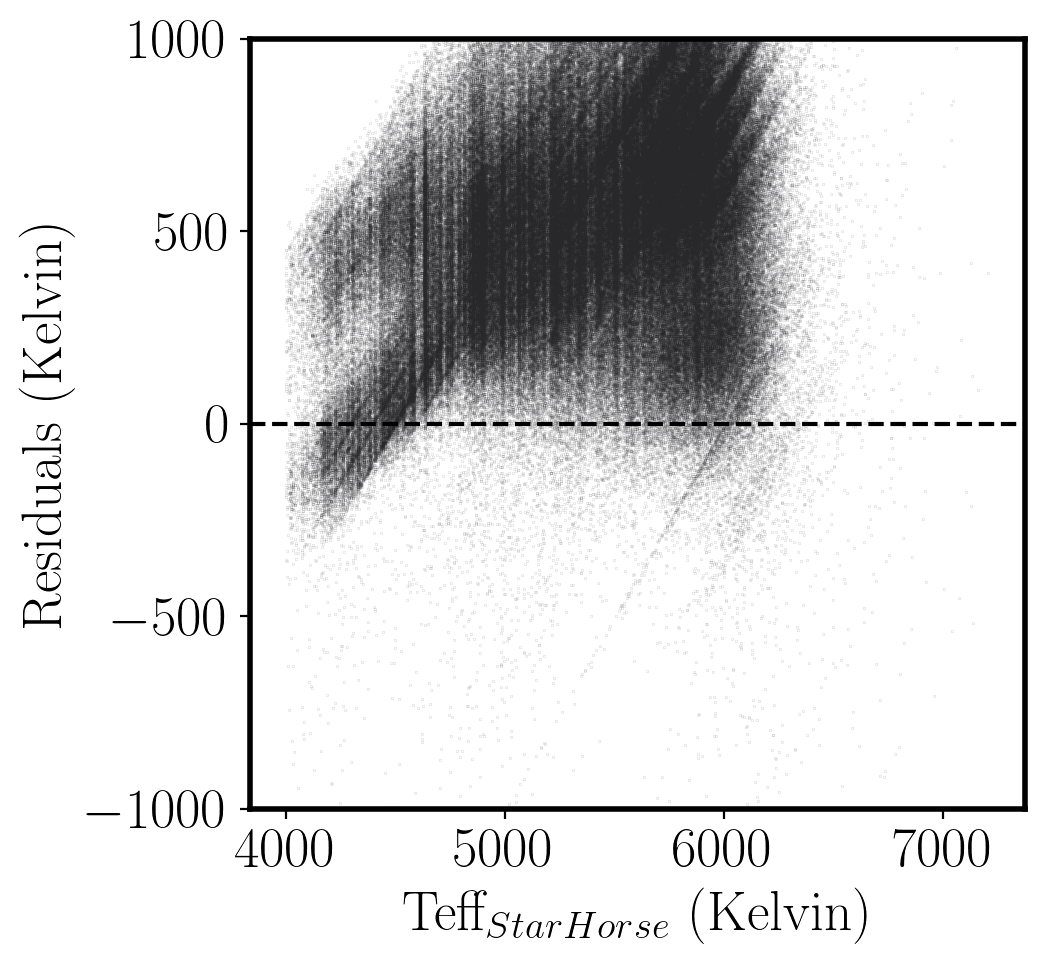

In [120]:
plt.figure(figsize=(5,5))
plt.scatter(sample_xmatch['teff50_StarHorse_'], sample_xmatch['teff50_StarHorse_'] - sample_xmatch['teff_gspphot_gaia'],
            s=0.001, color='#28282B')
plt.ylim(-1_000, 1_000)
plt.ylabel("Residuals (Kelvin)")
plt.xlabel("Teff$_{StarHorse}$ (Kelvin)")
plt.axhline(0, color='k', ls='--')

## Crossmatch to ZTF Object

In [121]:
%%time
# load ZTF object table
ztf = lsdb.read_hipscat("/epyc/data3/hipscat/catalogs/ztf_axs/ztf_dr14")

CPU times: user 497 ms, sys: 112 ms, total: 609 ms
Wall time: 570 ms


In [122]:
%%time
xmatch2 = fgk_object.crossmatch(ztf, n_neighbors=1, radius_arcsec=1, require_right_margin=False)

/epyc/users/atzanida/anaconda3/envs/lsdb_demo_true/lib/python3.10/site-packages/lsdb/dask/crossmatch_catalog_data.py:117: RuntimeWarning: Right catalog does not have a margin cache. Results may be inaccurate
  warnings.warn("Right catalog does not have a margin cache. Results may be inaccurate", RuntimeWarning)


CPU times: user 881 ms, sys: 58 ms, total: 939 ms
Wall time: 897 ms


In [135]:
xmatch2

,Source_StarHorse_,RA_ICRS_StarHorse_,DE_ICRS_StarHorse_,teff50_StarHorse_,logg50_StarHorse_,met50_StarHorse_,dist50_StarHorse_,fidelity_StarHorse_,GMAG0_StarHorse_,BP-RP0_StarHorse_,Norder_StarHorse_,Dir_StarHorse_,Npix_StarHorse_,ps1_objid_ztf_dr14_,ra_ztf_dr14_,dec_ztf_dr14_,ps1_gMeanPSFMag_ztf_dr14_,ps1_rMeanPSFMag_ztf_dr14_,ps1_iMeanPSFMag_ztf_dr14_,nobs_g_ztf_dr14_,nobs_r_ztf_dr14_,nobs_i_ztf_dr14_,mean_mag_g_ztf_dr14_,mean_mag_r_ztf_dr14_,mean_mag_i_ztf_dr14_,Norder_ztf_dr14_,Dir_ztf_dr14_,Npix_ztf_dr14_,_DIST_,Norder_,Dir_,Npix_,ps1_objid_ztf_dr14,ra_ztf_dr14,dec_ztf_dr14,ps1_gMeanPSFMag_ztf_dr14,ps1_rMeanPSFMag_ztf_dr14,ps1_iMeanPSFMag_ztf_dr14,nobs_g_ztf_dr14,nobs_r_ztf_dr14,nobs_i_ztf_dr14,mean_mag_g_ztf_dr14,mean_mag_r_ztf_dr14,mean_mag_i_ztf_dr14,Norder_ztf_dr14,Dir_ztf_dr14,Npix_ztf_dr14,_dist_arcsec
npartitions=2352,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64,uint8,uint64,uint64,int64,float64,float64,float64,float64,float64,int32,int32,int32,float64,float64,float64,int32,int32,int32,float64
18014398509481984,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13830554455654793216,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18446744073709551615,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
